In [1]:
import os
import torch
from torch import optim, nn, utils, Tensor
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

In [2]:
import numpy as np
import dataset as MOFdata

def filter_data(x):
    a, b = -4000, 5000
    mid = (a + b)/2
    dif = b-a
    # energy = x[0]
    energy = np.clip(x[0] - mid, a - mid, b - mid) / (dif / 2)
    # return np.array([x[1], x[2]])
    return np.array([energy, x[1], x[2]])


def filter_labels(x):
    return x[:3]

grid_file = "data/probability.npy"
csv_file = "data/ASR.csv"
lattice_file = "data/grids.lattice.npy"
feature = "lattice"

dataset = MOFdata.Dataset(grid_file, csv_file, lattice_file, feature, transform=filter_data, transform_labels=filter_labels)
train_set_size = int(.9 * len(dataset))
validation_set_size = int(.05 * len(dataset))
test_set_size = len(dataset) - train_set_size - validation_set_size
train_set, validation_set, test_set = random_split(
    dataset=dataset,
    lengths=(train_set_size,
    validation_set_size,
    test_set_size),
    generator=torch.Generator().manual_seed(42))

loader_args = dict(batch_size=64, num_workers=4)
train_loader = DataLoader(train_set, **loader_args)
validation_loader = DataLoader(validation_set, **loader_args)
test_loader = DataLoader(test_set, **loader_args)

a = np.min(train_set[0][0])
b = np.max(train_set[0][0])
small = 0
for x, _ in train_set:
    a = min(a, np.min(x))
    b = max(b, np.max(x))
print("small grids", small, len(train_set))
print("data shape", train_set[0][0].shape)
print("feature shape", train_set[0][1].shape, train_set[0][1])
print("data range", a, "->", b)

available features: 10143 available grids: 10140
0 missing features
small grids 0 9126
data shape (3, 32, 32, 32)
feature shape (3,) [14.932 14.932 11.956]
data range -0.48497555 -> 5.660271


In [3]:
import random
from basic_net import BasicModel

def loss_fn(output, target):
    return nn.functional.mse_loss(output, target)

def proportional_loss(output, target):
    return torch.mean(torch.abs(output-target)/torch.abs(target))

# define the LightningModule
class ModulePL(pl.LightningModule):
    def __init__(self, features=3, channels=3, dropout=0.5, device=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = BasicModel(features=features, channels=channels, dropout=dropout)
        # self.saved_model = saved_model
        self.activations = {}
        for name, child in self.model.named_children():
            # print(name, child)
            # break
            child.register_forward_hook(self.get_activation(name))
    
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = loss_fn(y.float(), y_hat)
        self.log("train_loss", loss)
        return loss
    
    def get_activation(self, name):
        def hook(model, input, output):
            self.activations[name] = output.detach()
        return hook
        

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y = y.float()
        y_hat = self.forward(x)
        loss = loss_fn(y_hat, y)
        l1_loss = nn.functional.l1_loss(y_hat, y)

        self.log('validation_loss', loss)
        self.log('validation_l1_loss', l1_loss)
        self.log('validation_p_loss', proportional_loss(y_hat, y))
        # if not self.global_step % 1000:
        for name, values in self.activations.items():
            self.log(f'activations/{name}-max', torch.max(torch.abs(values)).item())
        return loss

    def configure_optimizers(self):
        # optimizer = optim.Adam(self.parameters(), lr=1e-3, amsgrad=True)
        optimizer = optim.SGD(self.parameters(), lr=1e-3, momentum=0.99, nesterov=True)
        # optimizer = optim.Adadelta(self.parameters(), lr=1e-3)
        return dict(optimizer=optimizer, lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, cooldown=20, verbose=True), monitor="validation_loss")
        # return optimizer


model = ModulePL()

layer1 Sequential(
  (0): Conv3d(3, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=same, padding_mode=circular)
  (1): ReLU()
  (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
layer2 Sequential(
  (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.5, inplace=False)
)
layer3 Sequential(
  (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.5, inplace=False)
)
fc Sequential(
  (0): Linear(in_features=2048, out_features=64, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.5, inplace=False)
)
final Linear(in_features=64, out_features=3, bias=True)


In [4]:
# set up trainer
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

wandb_logger = WandbLogger(project="lattice", log_model="all")
chkpt_dir = "./lattice_pt"
checkpoint_callback = ModelCheckpoint(dirpath=chkpt_dir, save_top_k=2, monitor="validation_loss")

wandb: Currently logged in as: efergus3. Use `wandb login --relogin` to force relogin


In [ ]:

wandb_logger.watch(model.model)
# train
trainer = pl.Trainer(
    logger = wandb_logger,
    limit_train_batches=100,
    limit_val_batches=10,
    max_epochs=100,
    gradient_clip_val=0.5,
    accelerator='gpu',
    callbacks=[checkpoint_callback],
)

# train the model
trainer.fit(model=model, train_dataloaders=train_loader,  val_dataloaders=validation_loader)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/efergus3/miniconda3/envs/mof/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/efergus3/Materials/Materials-Search/Screening/lattice_pt exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | BasicModel | 198 K 
-------------------------------------
198 K     Trainable params
0         Non-trainable params
198 K     Total params
0.795     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00038: reducing learning rate of group 0 to 2.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


In [ ]:
import itertools
def predict(model, loader, count):
    correct = []
    predictions = []
    with torch.no_grad():
        for data_x, data_y in itertools.islice(loader, count):
            pred_y = model(data_x)
            for d, p in zip(data_y, pred_y):
                correct.append(np.array(d.detach()))
                predictions.append(np.array(p.detach()))
            if len(correct) > count:
                break
        return np.array(predictions), np.array(correct)

In [7]:
# load most recent model
import util
checkpoint = util.latest_file(chkpt_dir)
print("loading", checkpoint)
model = ModulePL.load_from_checkpoint(checkpoint)

loading ./lattice_pt/epoch=8-step=900.ckpt


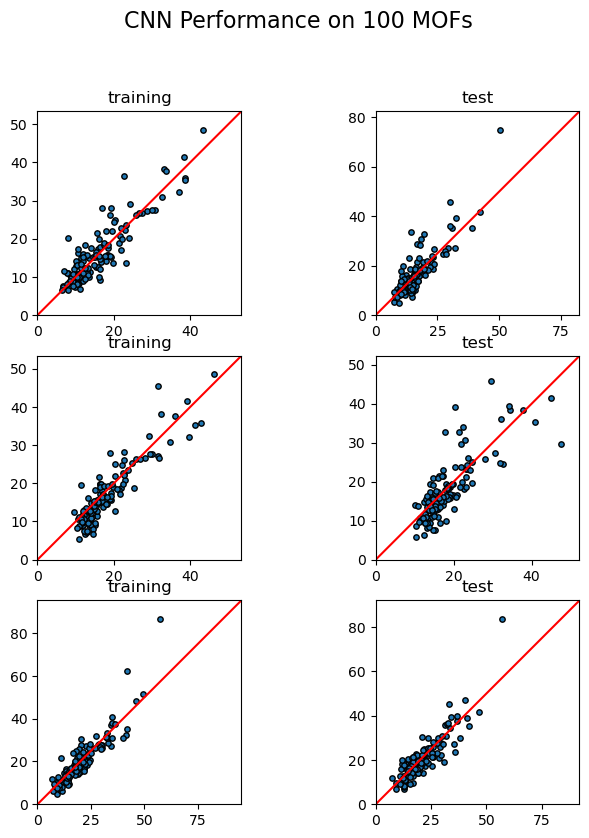

In [8]:
# plot performance
import matplotlib.pyplot as plt

count = min(100, test_set_size)

feature_range = (0, 3)
loaders = dict(
    training=train_loader,
    test=test_loader
)
fig, axs = plt.subplots(feature_range[1]-feature_range[0], len(loaders), figsize=(len(loaders)*4, 3*(feature_range[1]-feature_range[0])), dpi=100)
fig.suptitle(f"CNN Performance on {count} MOFs", fontsize=16, verticalalignment='center')

for i, (title, loader) in enumerate(loaders.items()):
    x, x_hat = predict(model, loader, count)
    for feature_idx in range(*feature_range):
        ax = axs[feature_idx][i]
        fx = x[:,feature_idx]
        fx_hat = x_hat[:,feature_idx]
        lim = [0, max(*fx, *fx_hat)*1.1]
        ax.scatter(fx, fx_hat, s=15, linewidths=1, edgecolors='black')

        ax.title.set_text(title)
        ax.set_aspect('equal')
        ax.set_xlim(lim)
        ax.set_ylim(lim)
        # plt.xscale('log')
        # plt.yscale('log')
        ax.plot([0, lim[1]], [0, lim[1]], color='red')

plt.show()

In [10]:
# load specific model
import util
from basic_net import BasicModel
if True:
    # checkpoint = "lattice_pt/saved_checkpoints/basic_net_lattice_constants/epoch=216-step=21700.ckpt"
    # print("loading", checkpoint)
    # saved_model = ModulePL.load_from_checkpoint(checkpoint)
    # torch.save(saved_model.model.state_dict(), "lattice_pt/saved_checkpoints/basic_net_lattice_constants/model.pt")
    saved_model = BasicModel(6, 3, 32, 0.2)
    saved_model.load_state_dict(torch.load("lattice_pt/saved_checkpoints/basic_net_lattice_constants/model.pt"))
    saved_model.requires_grad_(False)